In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('C:/Users/SEC/TIL/210709/DataSet.csv',index_col=0)

In [3]:
data.head()

,Date,SO2,CO,O3,NO2,PM10,PM25,Temp,Prec,WS,Humi,Pres,cbwd
Station code,,,,,,,,,,,,,
111121,2018-01-01,0.004833,0.554167,0.014583,0.029292,32.666667,17.791667,-1.3,0.0,1.4,39.1,1016.8,290
111122,2018-01-01,0.005417,0.541667,0.011375,0.039750,49.541667,19.899749,-1.3,0.0,1.4,39.1,1016.8,290
111123,2018-01-01,0.007208,0.604167,0.015292,0.030250,34.375000,17.333333,-1.3,0.0,1.4,39.1,1016.8,290
111124,2018-01-01,0.006333,0.433333,0.011542,0.034167,37.125000,19.899749,-1.3,0.0,1.4,39.1,1016.8,290
111125,2018-01-01,0.003667,0.495833,0.020833,0.028708,36.208333,19.899749,-1.3,0.0,1.4,39.1,1016.8,290


In [4]:
data1=data.groupby('Date').mean().copy()

In [5]:
data1.drop(['SO2','CO','O3','NO2','PM10','Temp','Prec','WS','Humi','Pres','cbwd'],axis=1,inplace=True)

<AxesSubplot:xlabel='Date'>

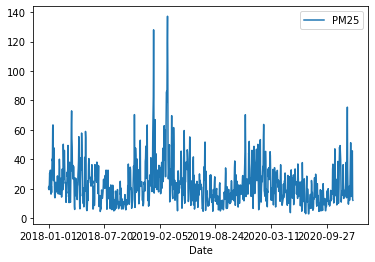

In [6]:
data1.plot()

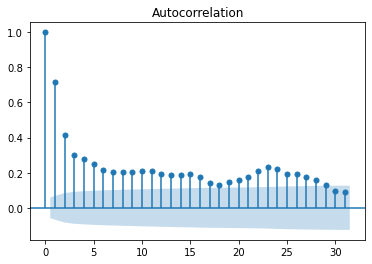

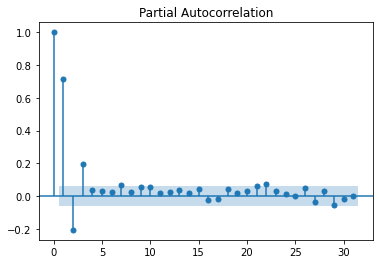

In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data1)
plot_pacf(data1)
plt.show()

ACF가 양수이므로 AR 모델을 사용한다. arima(p,d,0)

## 1차 차분

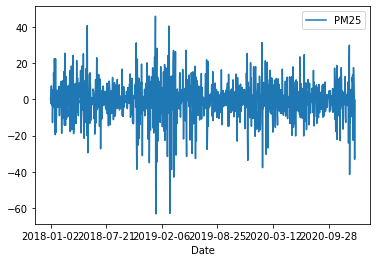

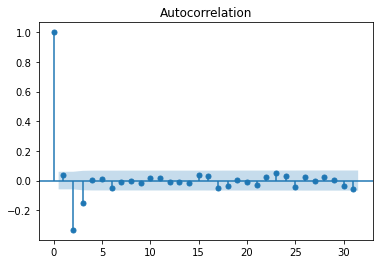

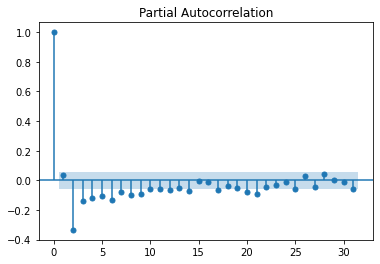

In [8]:
diff_1=data1.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

In [9]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


model = ARIMA(data1, order=(2,1,0))

#trend : constant를 가지고 있는지, c - constant / nc - no constant
#disp : 수렴 정보를 나타냄
model_fit = model.fit(trend='nc', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observations:                 1095
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4092.532
Method:                       css-mle   S.D. of innovations             10.160
Date:                Tue, 13 Jul 2021   AIC                           8191.064
Time:                        17:27:16   BIC                           8206.059
Sample:                    01-02-2018   HQIC                          8196.738
                         - 12-31-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.PM25     0.0461      0.028      1.621      0.105      -0.010       0.102
ar.L2.D.PM25    -0.3367      0.029    -11.793      0.000      -0.393      -0.281
                                    Roots   

C:\Users\SEC\anaconda3\envs\multi\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\SEC\anaconda3\envs\multi\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferr

C:\Users\SEC\anaconda3\envs\multi\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


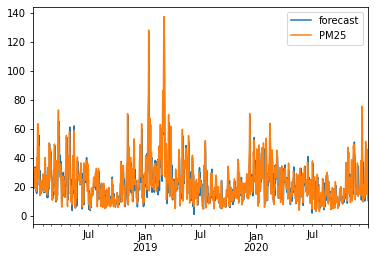

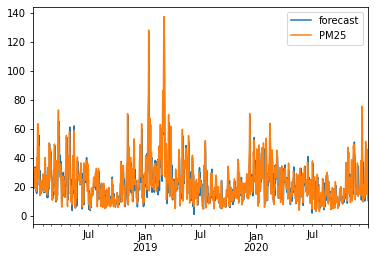

In [10]:
model_fit.plot_predict()

In [11]:
fore = model_fit.forecast(steps=60)

In [26]:
mae = mean_absolute_error(fore[0],y_test)
print('MAE: %.3f' % mae)
mse = mean_squared_error(fore[0],y_test)
print('MSE: %.3f' % mse)

MAE: 9.907
MSE: 144.761


In [13]:
data1.reset_index(inplace=True)
data1

,Date,PM25
0,2018-01-01,20.671076
1,2018-01-02,21.590346
2,2018-01-03,19.385637
3,2018-01-04,23.229592
4,2018-01-05,30.603990
...,...,...
1091,2020-12-27,41.449547
1092,2020-12-28,43.797336
1093,2020-12-29,45.760417
1094,2020-12-30,12.663609


In [14]:
from fbprophet import Prophet

# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
data1.columns=['ds','y']
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(data1)

Importing plotly failed. Interactive plots will not work.


In [15]:
future_data = prophet.make_future_dataframe(periods=60, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1151,2021-02-25,40.407596,18.580440,64.663862
1152,2021-02-26,43.653674,20.045448,66.557682
1153,2021-02-27,45.698617,21.067351,71.561492
1154,2021-02-28,44.333192,19.872011,68.300223
1155,2021-03-01,45.980881,19.846024,70.990246


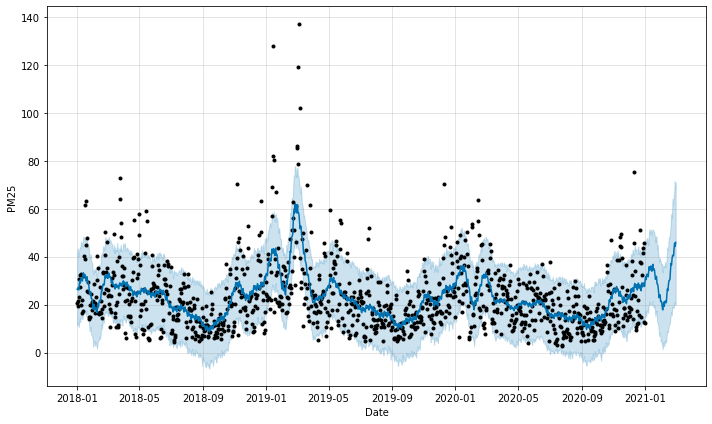

In [21]:
fig1 = prophet.plot(forecast_data,xlabel='Date',ylabel='PM25')

In [17]:
y_test=forecast_data['yhat'][-60:]

In [18]:
test=pd.read_csv('testset.csv')

In [22]:
x_test=test.PM25[:-1]

In [25]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
mae = mean_absolute_error(x_test,y_test)
mse = mean_squared_error(x_test,y_test)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)

MAE: 14.147
MSE: 276.728
